In [1]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px
import csv 


%matplotlib inline
current_directory=  os.path.dirname(os.getcwd())

In [2]:
data = ANT.importDatafile(current_directory+"\\ProAnubisData\\threeHourRun_24_3_1.h5")

etaHits, phiHits, number_corruptions, tdc_corruptions = ANT.divideHitCountsByRPC_Timed_UNCORRUPTED(data)

#ANT.importDatafile is from original scripts. ANT.divideHitCountsByRPC_Timed() is modified from original scripts. All other functions are new.

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_3hrs_cosmics = ANT.FindCoincidentHits(etaHits,phiHits,15)

#Spatial Clustering
coincident_hits_3hrs_clustered = ANT.cluster(coincident_hits_3hrs_cosmics)

5
5
5
5
5
HERE:1262
4
Corrupted Event, 1 corrupted events
HERE:1579
HERE:1612
4
Corrupted Event, 2 corrupted events
5
5
5
HERE:1497
HERE:1583
HERE:1538
HERE:1580
2
Corrupted Event, 4 corrupted events
HERE:2212
4
Corrupted Event, 1 corrupted events
5
5
5
5
HERE:2027
4
Corrupted Event, 1 corrupted events
5
5
HERE:2861
4
Corrupted Event, 1 corrupted events
5
5
5
5
5
5
5
5
5
HERE:1267
HERE:1264
HERE:1264
HERE:1310
HERE:1410
2
Corrupted Event, 5 corrupted events
5
5
5
5
5
5
5
5
5
5
5
5
5
5
HERE:1279
HERE:1276
HERE:1366
3
Corrupted Event, 3 corrupted events
5
5
5
HERE:1296
4
Corrupted Event, 1 corrupted events
5
5
HERE:1412
HERE:1391
3
Corrupted Event, 2 corrupted events
5
5
HERE:1313
HERE:1312
HERE:1304
HERE:1349
HERE:1344
HERE:1345
HERE:1394
HERE:1500
HERE:1493
0
Corrupted Event, 9 corrupted events
5
5
5
5
5
HERE:1285
HERE:1385
4
Corrupted Event, 2 corrupted events
5
5
5
5
5
5
HERE:1365
HERE:1339
4
Corrupted Event, 2 corrupted events
5
5
HERE:1475
HERE:1563
HERE:1472
HERE:1513
HERE:1447
HE

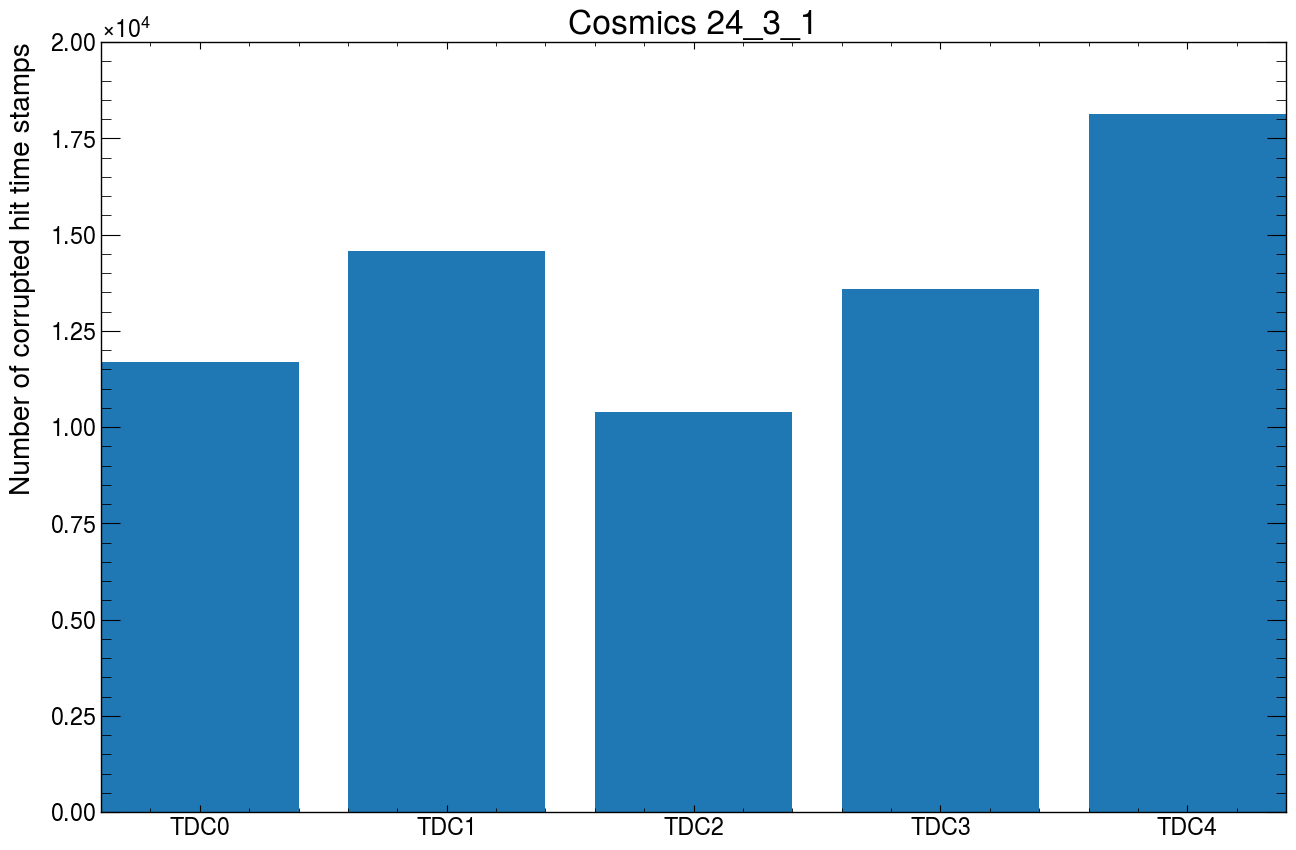

In [4]:
x_marks = ['TDC0','TDC1','TDC2','TDC3','TDC4']

plt.figure(figsize=(15,10))

plt.bar(x_marks,tdc_corruptions)
plt.ylabel('Number of corrupted hit time stamps')
#plt.yscale('log')

plt.title("Cosmics 24_3_1")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


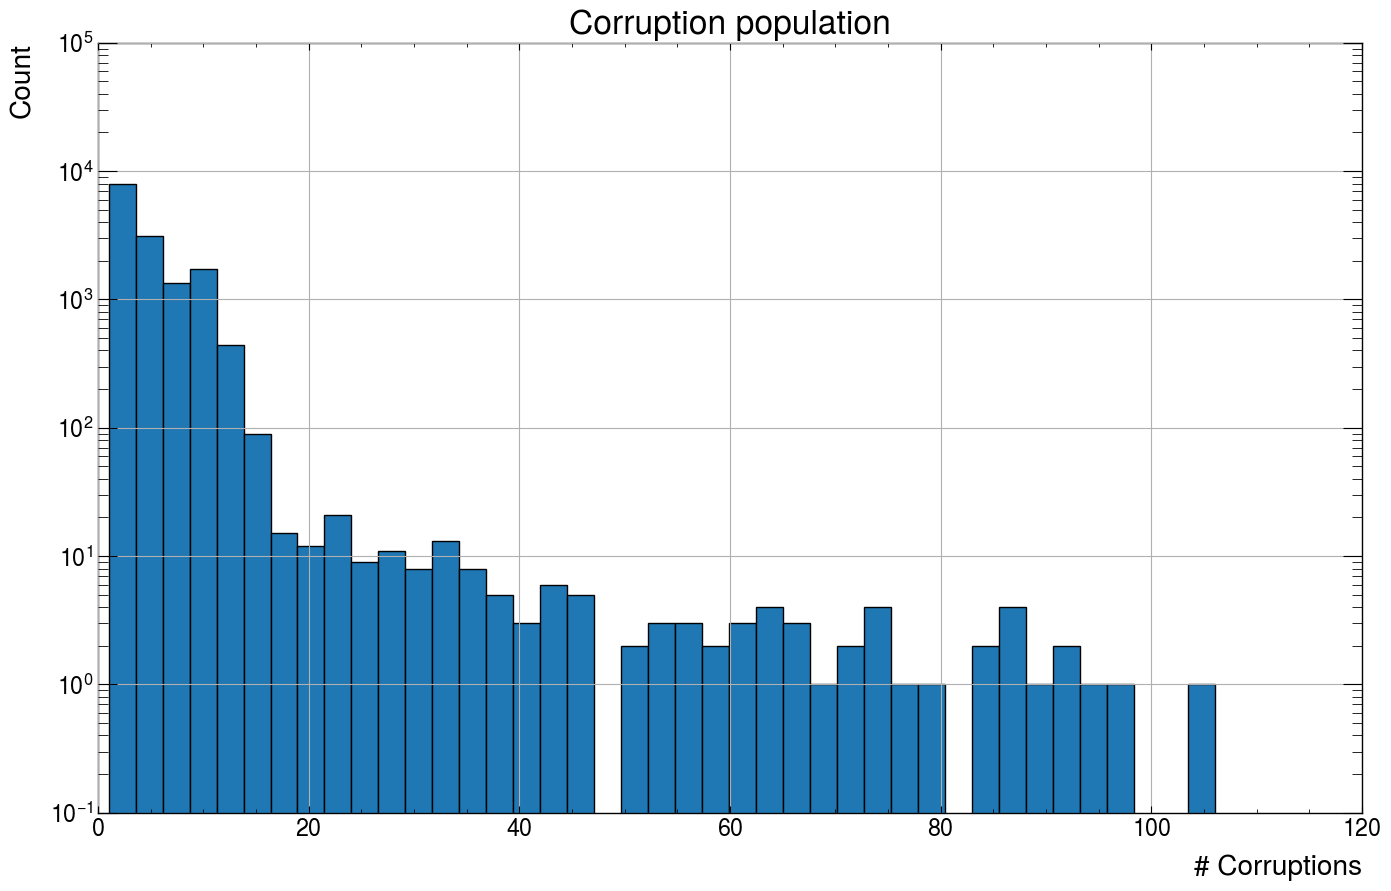

In [6]:
plt.figure(figsize=(16, 10))

# Plot histogram with counts
plt.hist(number_corruptions, bins=41, density=False, edgecolor='black')

# # Set x-ticks spacing to 1
# plt.xticks(np.arange(-20, 21, 2))
# Customize the plot
plt.xlabel('# Corruptions')
plt.ylabel('Count')
plt.title("Corruption population")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    #The user selects an RPC to exclude from the filter. 
    #e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4. The check_event_...() will check if the
    #event has atleast 4 RPCs hit.

    #USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):

        if RPC ==  RPC_excluded:
            pass
        else:
            if RPC<3:
                #Checking triplet layer.
                if event[2][RPC][1]:
                    #Reqiure atleast one eta strip to go off
                    RPC_counter+=1 
                    #If RPC has two eta and phi strips going off then consider it "hit"
                    if not condition_1:
                        #Count triplet chamber being hit.
                        chamber_counter+=1
                        condition_1 = True
            elif RPC == 3:
                #Singlet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_2:
                        chamber_counter+=1
                        condition_2 = True
            else:
                #Doublet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_3:
                        chamber_counter+=1
                        condition_3 = True
    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number

def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events

def reconstruct_timed_byRPC(event,max_cluster_size,RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_residual = 100

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = ANT.extract_coords_timed(event,max_cluster_size)
    #print(coords)

    #UPDATE COORDS TO IGNORE THE RPC UNDER TEST

    test_coords = coords[RPC_excluded]
    coords[RPC_excluded] = [[],[],"N"]

    dT = ANT.extract_DT(coords)

    #print(coords)

    if dT is None:
        #print("Failed to reconstruct, dT is NoneType")
        return None

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = ANT.generate_hit_coords_combo(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    residuals_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None

    for ind,combo in enumerate(combinations):

        centroid, d, residuals = ANT.fit_event(combo)
        if residuals < residuals_current:

            # If new fit is better than old then replace old fit.
            residuals_current = residuals
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = combinations[ind]

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT > 0:
        if optimised_d[2] < 0:
            optimised_d = np.multiply(optimised_d,-1)
    else:
        if optimised_d[2] > 0:
            optimised_d = np.multiply(optimised_d,-1)

    if residuals_current<max_residual:
        return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current, dT, test_coords
    else:
        #print("Failed to reconstruct, residuals too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
    
def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

   # print(test_coords)

    if test_coords != [[],[],"N"]: 

        t = test_coords[:-1]# Doing this because .pop() seems to act globally...

        for x in t[0]:
            for y in t[1]:

                #print([x,y])
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False

def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None   

def calc_efficiency_RPC(dataset,RPC,tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # tol is tolerance on checkHit in cm.

    events = filter_events_by_RPC(dataset,2,5,RPC)

    possible_reconstructions = 0
    successful_reconstructions = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_byRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:

                    possible_reconstructions+=1 

                    check = does_RPC_detect_muon(muon_coords,E_recon[6],tol)

                    if check:
                        successful_reconstructions+=1 

    print(possible_reconstructions)
    print(successful_reconstructions)

    return successful_reconstructions/possible_reconstructions

0.0
898
0
0.40816326530612246
898
100
0.8163265306122449
898
226
1.2244897959183674
898
351
1.6326530612244898
898
456
2.0408163265306123
898
519
2.4489795918367347
898
551
2.857142857142857
898
571
3.2653061224489797
898
582
3.673469387755102
898
588
4.081632653061225
898
592
4.4897959183673475
898
594
4.8979591836734695
898
597
5.3061224489795915
898
598
5.714285714285714
898
599
6.122448979591837
898
602
6.530612244897959
898
602
6.938775510204081
898
602
7.346938775510204
898
602
7.755102040816327
898
602
8.16326530612245
898
603
8.571428571428571
898
603
8.979591836734695
898
603
9.387755102040817
898
604
9.795918367346939
898
604
10.204081632653061
898
605
10.612244897959183
898
606
11.020408163265307
898
606
11.428571428571429
898
606
11.83673469387755
898
606
12.244897959183675
898
606
12.653061224489797
898
607
13.061224489795919
898
607
13.46938775510204
898
607
13.877551020408163
898
607
14.285714285714286
898
607
14.693877551020408
898
607
15.10204081632653
898
607
15.51020

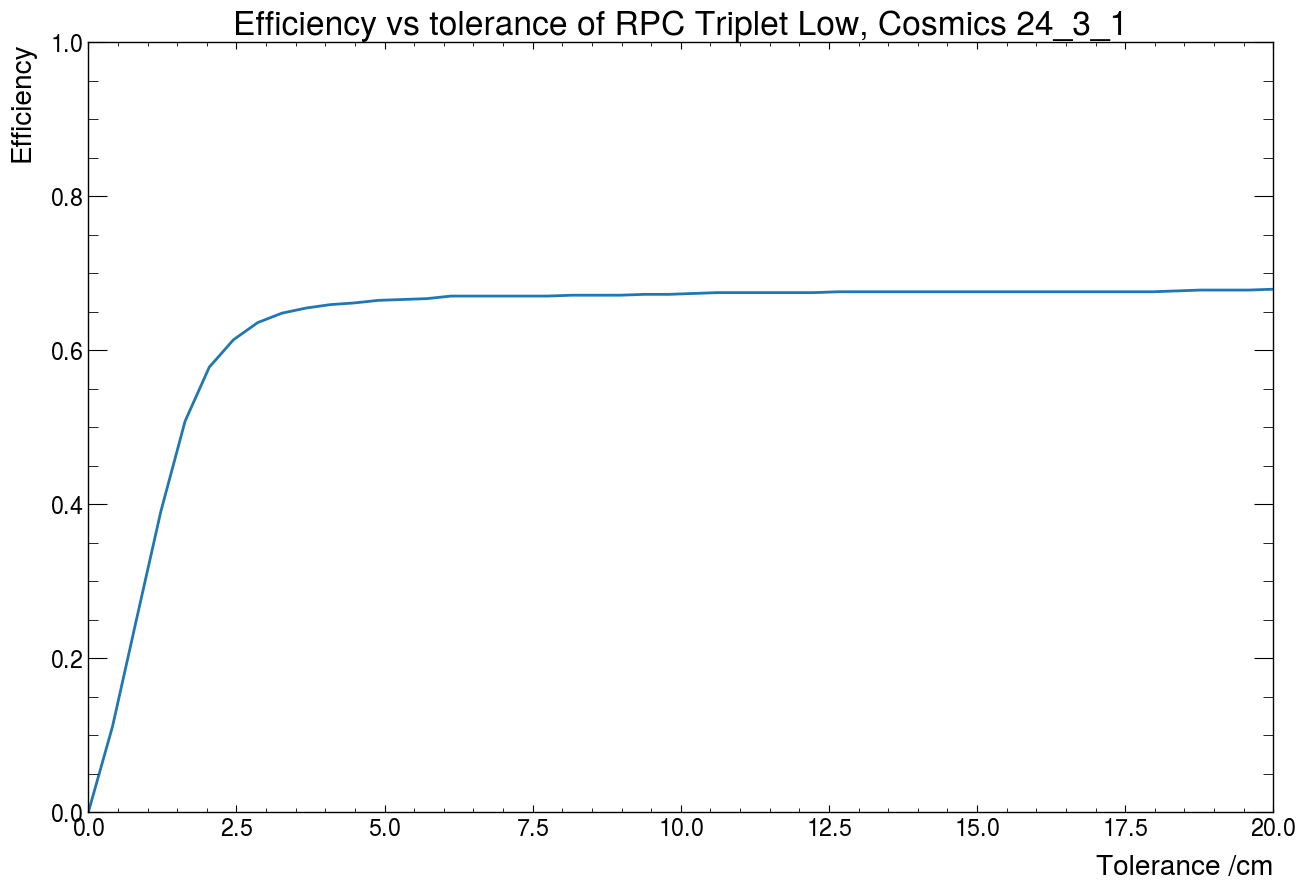

In [11]:
tolerances = np.linspace(0,20,50)

efficiencies1 = []

for tol in tolerances:
    print(tol)
    efficiencies1.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,0,tol))

# Zip the nested lists together
toWrite = zip(efficiencies1, tolerances)

with open('TripletLow.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies1)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Low, Cosmics 24_3_1')

plt.show()

0.0
808
0
0.40816326530612246
808
76
0.8163265306122449
808
207
1.2244897959183674
808
331
1.6326530612244898
808
432
2.0408163265306123
808
512
2.4489795918367347
808
560
2.857142857142857
808
584
3.2653061224489797
808
596
3.673469387755102
808
599
4.081632653061225
808
602
4.4897959183673475
808
606
4.8979591836734695
808
607
5.3061224489795915
808
608
5.714285714285714
808
611
6.122448979591837
808
611
6.530612244897959
808
611
6.938775510204081
808
612
7.346938775510204
808
612
7.755102040816327
808
612
8.16326530612245
808
612
8.571428571428571
808
613
8.979591836734695
808
613
9.387755102040817
808
614
9.795918367346939
808
615
10.204081632653061
808
615
10.612244897959183
808
616
11.020408163265307
808
616
11.428571428571429
808
616
11.83673469387755
808
616
12.244897959183675
808
616
12.653061224489797
808
616
13.061224489795919
808
616
13.46938775510204
808
617
13.877551020408163
808
617
14.285714285714286
808
617
14.693877551020408
808
618
15.10204081632653
808
618
15.510204

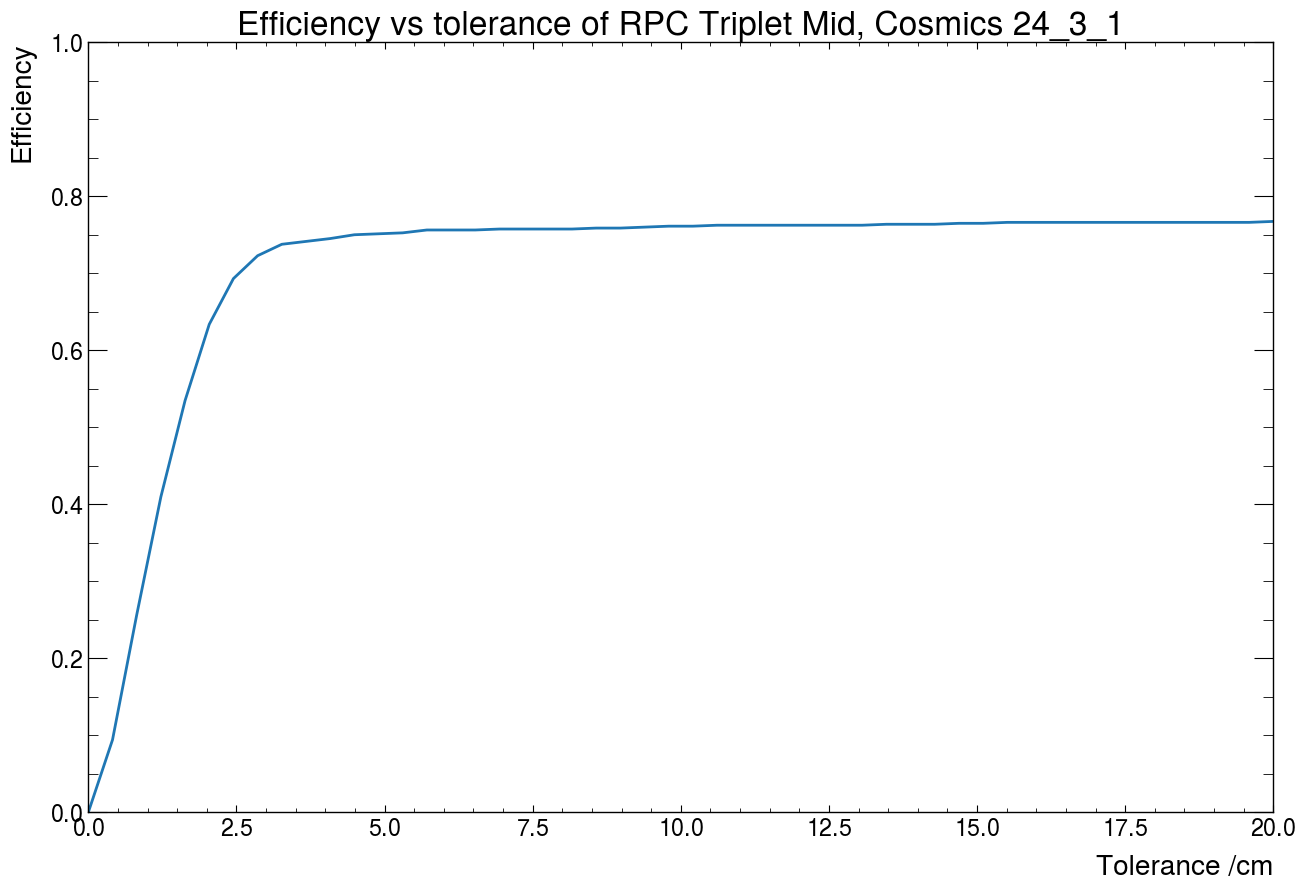

In [12]:
tolerances = np.linspace(0,20,50)

efficiencies2 = []

for tol in tolerances:
    print(tol)
    efficiencies2.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,1,tol))

# Zip the nested lists together
toWrite = zip(efficiencies2, tolerances)

with open('TripletMid.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies2)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Mid, Cosmics 24_3_1')

plt.show()

0.0
942
0
0.40816326530612246
942
64
0.8163265306122449
942
197
1.2244897959183674
942
354
1.6326530612244898
942
478
2.0408163265306123
942
548
2.4489795918367347
942
574
2.857142857142857
942
589
3.2653061224489797
942
601
3.673469387755102
942
605
4.081632653061225
942
607
4.4897959183673475
942
608
4.8979591836734695
942
609
5.3061224489795915
942
610
5.714285714285714
942
611
6.122448979591837
942
611
6.530612244897959
942
611
6.938775510204081
942
612
7.346938775510204
942
613
7.755102040816327
942
613
8.16326530612245
942
613
8.571428571428571
942
613
8.979591836734695
942
613
9.387755102040817
942
613
9.795918367346939
942
614
10.204081632653061
942
615
10.612244897959183
942
616
11.020408163265307
942
616
11.428571428571429
942
616
11.83673469387755
942
617
12.244897959183675
942
617
12.653061224489797
942
617
13.061224489795919
942
618
13.46938775510204
942
618
13.877551020408163
942
618
14.285714285714286
942
618
14.693877551020408
942
618
15.10204081632653
942
618
15.510204

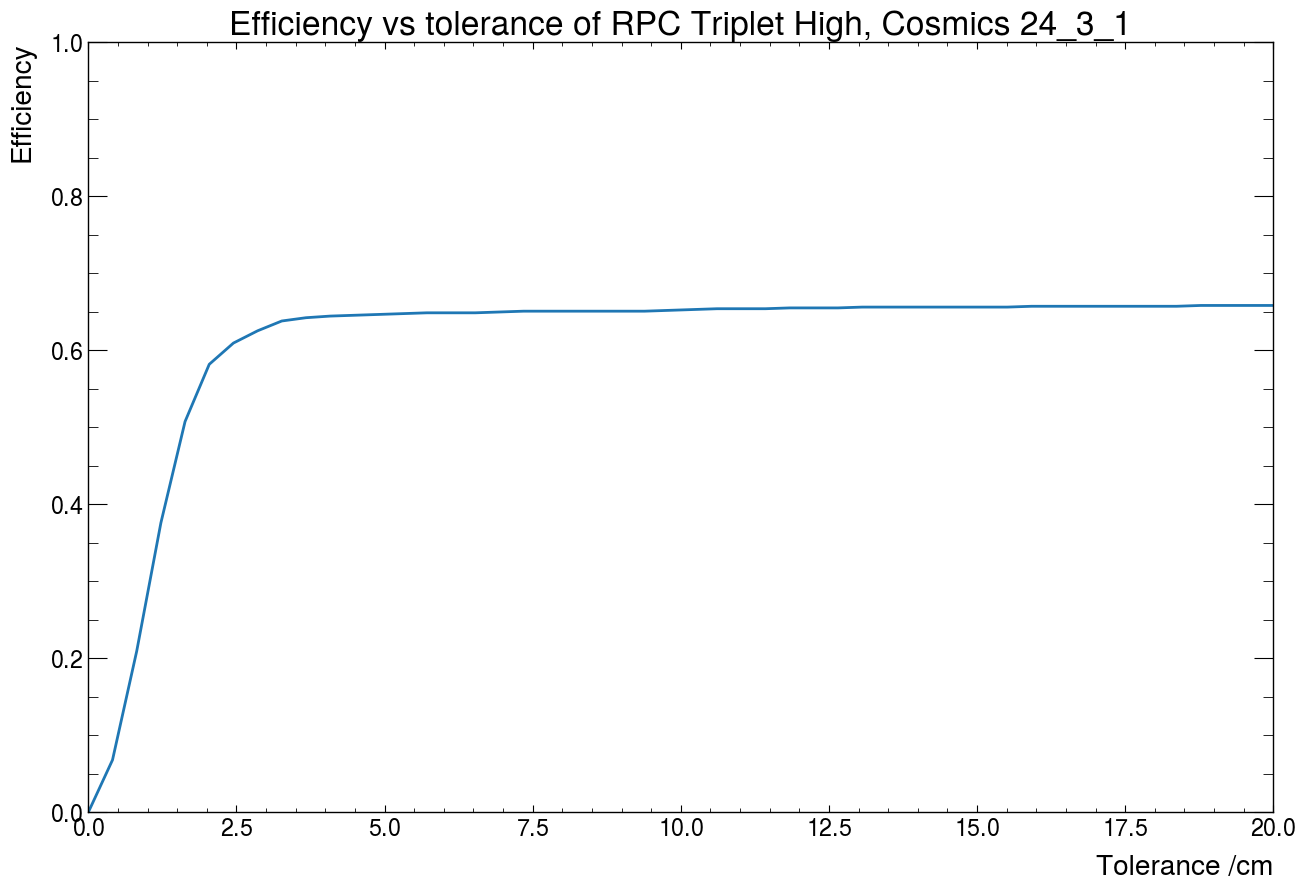

In [13]:
tolerances = np.linspace(0,20,50)

efficiencies3 = []

for tol in tolerances:
    print(tol)
    efficiencies3.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,2,tol))

# Zip the nested lists together
toWrite = zip(efficiencies3, tolerances)

with open('TripletHigh.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies3)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet High, Cosmics 24_3_1')

plt.show()

0.0
892
0
0.40816326530612246
892
22
0.8163265306122449
892
55
1.2244897959183674
892
96
1.6326530612244898
892
170
2.0408163265306123
892
240
2.4489795918367347
892
316
2.857142857142857
892
391
3.2653061224489797
892
440
3.673469387755102
892
485
4.081632653061225
892
519
4.4897959183673475
892
550
4.8979591836734695
892
568
5.3061224489795915
892
578
5.714285714285714
892
586
6.122448979591837
892
592
6.530612244897959
892
595
6.938775510204081
892
598
7.346938775510204
892
600
7.755102040816327
892
601
8.16326530612245
892
602
8.571428571428571
892
604
8.979591836734695
892
606
9.387755102040817
892
608
9.795918367346939
892
610
10.204081632653061
892
610
10.612244897959183
892
610
11.020408163265307
892
610
11.428571428571429
892
612
11.83673469387755
892
612
12.244897959183675
892
614
12.653061224489797
892
617
13.061224489795919
892
617
13.46938775510204
892
617
13.877551020408163
892
617
14.285714285714286
892
618
14.693877551020408
892
619
15.10204081632653
892
619
15.51020408

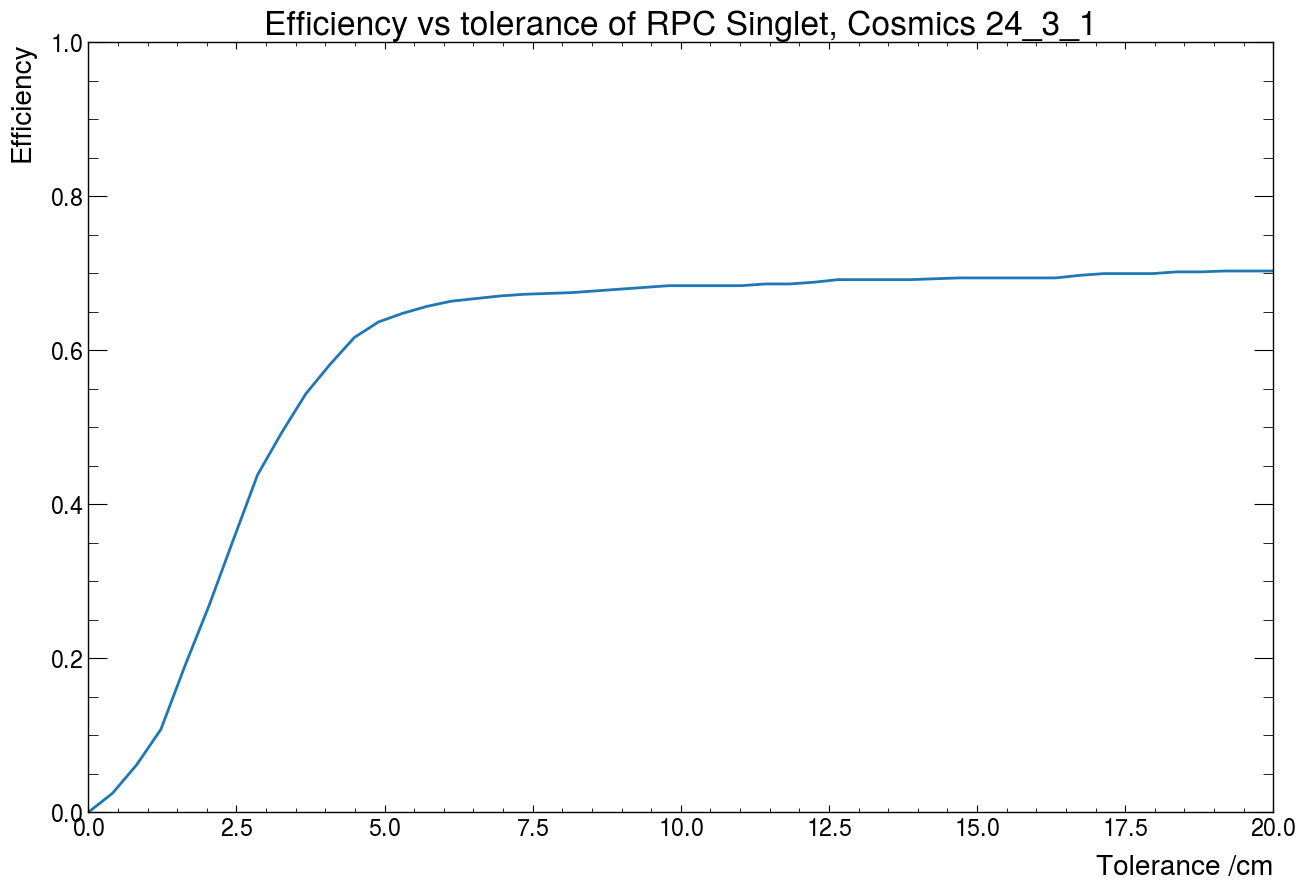

In [14]:
tolerances = np.linspace(0,20,50)

efficiencies4 = []

for tol in tolerances:
    print(tol)
    efficiencies4.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,3,tol))

# Zip the nested lists together
toWrite = zip(efficiencies4, tolerances)

with open('Singlet.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies4)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Singlet, Cosmics 24_3_1')

plt.show()

0.0
872
0
0.40816326530612246
872
57
0.8163265306122449
872
133
1.2244897959183674
872
189
1.6326530612244898
872
284
2.0408163265306123
872
384
2.4489795918367347
872
443
2.857142857142857
872
479
3.2653061224489797
872
507
3.673469387755102
872
535
4.081632653061225
872
544
4.4897959183673475
872
552
4.8979591836734695
872
555
5.3061224489795915
872
556
5.714285714285714
872
558
6.122448979591837
872
559
6.530612244897959
872
560
6.938775510204081
872
561
7.346938775510204
872
562
7.755102040816327
872
564
8.16326530612245
872
564
8.571428571428571
872
567
8.979591836734695
872
571
9.387755102040817
872
572
9.795918367346939
872
572
10.204081632653061
872
573
10.612244897959183
872
574
11.020408163265307
872
575
11.428571428571429
872
576
11.83673469387755
872
576
12.244897959183675
872
577
12.653061224489797
872
578
13.061224489795919
872
578
13.46938775510204
872
579
13.877551020408163
872
579
14.285714285714286
872
580
14.693877551020408
872
582
15.10204081632653
872
582
15.510204

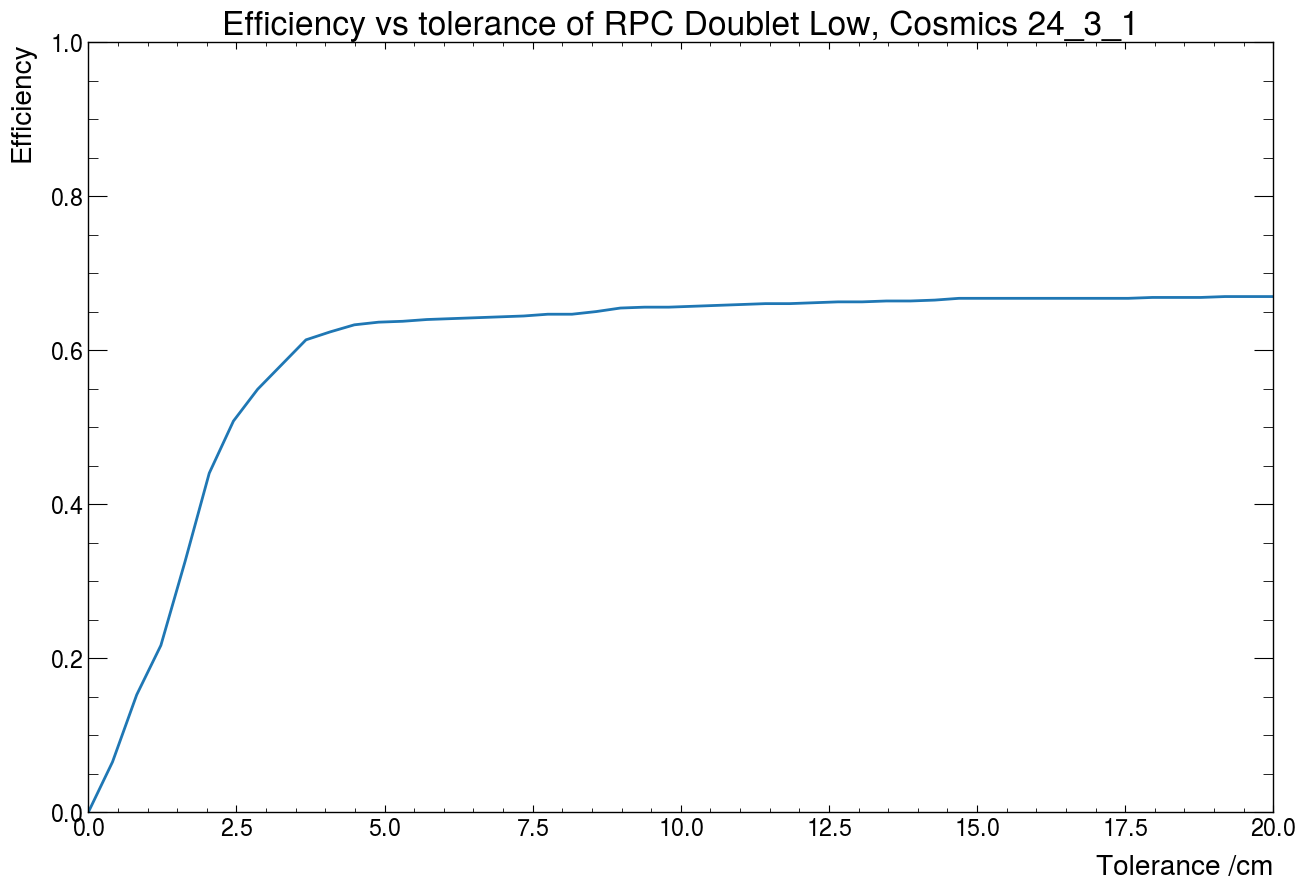

In [15]:
tolerances = np.linspace(0,20,50)

efficiencies5 = []

for tol in tolerances:
    print(tol)
    efficiencies5.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,4,tol))

# Zip the nested lists together
toWrite = zip(efficiencies5, tolerances)

with open('DoubletLow.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies5)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet Low, Cosmics 24_3_1')

plt.show()

0.0
792
0
0.40816326530612246
792
40
0.8163265306122449
792
140
1.2244897959183674
792
236
1.6326530612244898
792
353
2.0408163265306123
792
437
2.4489795918367347
792
502
2.857142857142857
792
530
3.2653061224489797
792
546
3.673469387755102
792
552
4.081632653061225
792
557
4.4897959183673475
792
558
4.8979591836734695
792
559
5.3061224489795915
792
560
5.714285714285714
792
564
6.122448979591837
792
564
6.530612244897959
792
565
6.938775510204081
792
567
7.346938775510204
792
568
7.755102040816327
792
568
8.16326530612245
792
569
8.571428571428571
792
569
8.979591836734695
792
569
9.387755102040817
792
570
9.795918367346939
792
570
10.204081632653061
792
570
10.612244897959183
792
572
11.020408163265307
792
573
11.428571428571429
792
573
11.83673469387755
792
575
12.244897959183675
792
577
12.653061224489797
792
580
13.061224489795919
792
580
13.46938775510204
792
580
13.877551020408163
792
581
14.285714285714286
792
581
14.693877551020408
792
581
15.10204081632653
792
581
15.510204

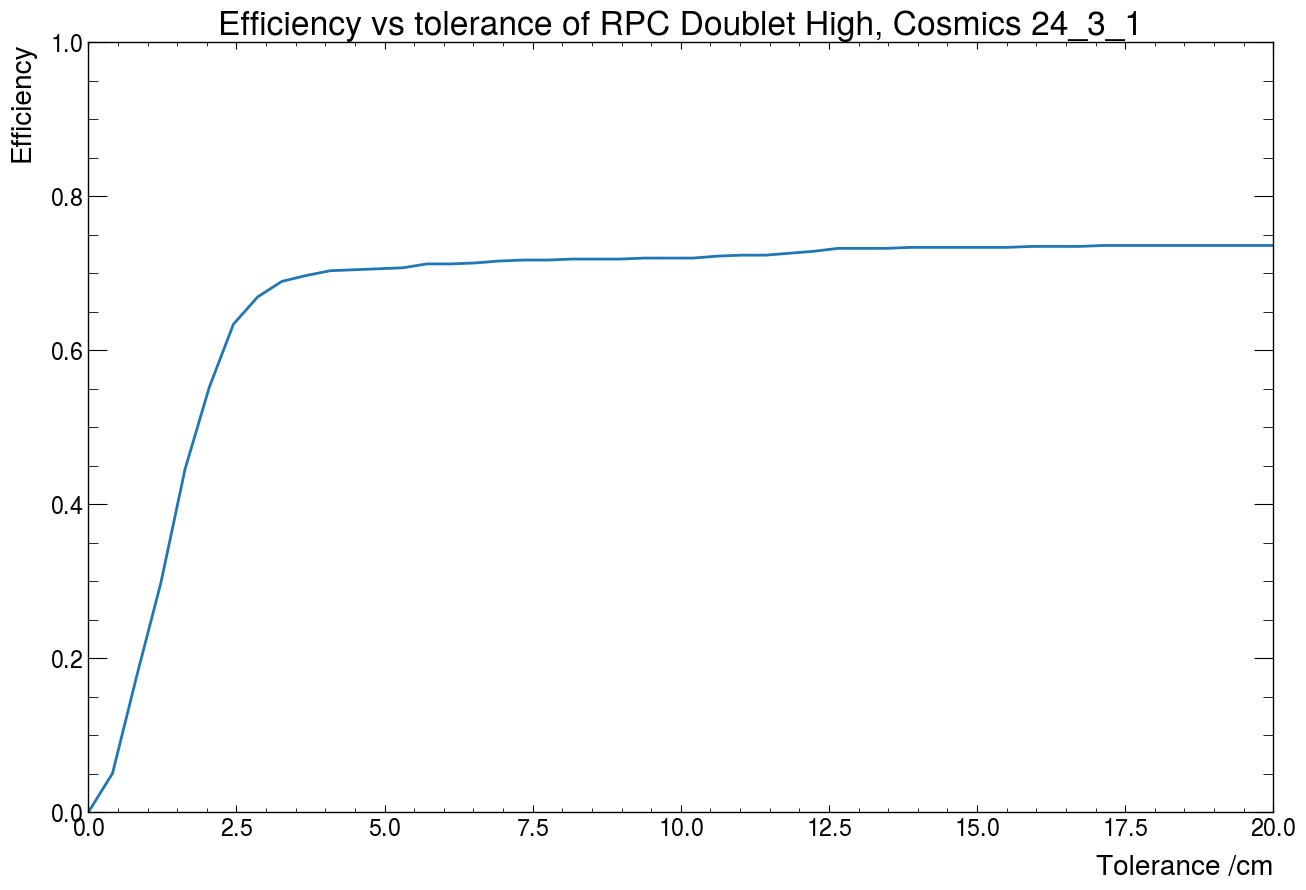

In [16]:
tolerances = np.linspace(0,20,50)

efficiencies6 = []

for tol in tolerances:
    print(tol)
    efficiencies6.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,5,tol))

# Zip the nested lists together
toWrite = zip(efficiencies6, tolerances)

with open('DoubletHigh.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies6)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet High, Cosmics 24_3_1')

plt.show()

In [17]:

def plotPhi(array, name, zrange = [0.01,200], unit='khz', time=60.):
    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    phichannels = [x-0.5 for x in range(65)]
    phiHist = ((np.array([array])/time).transpose(),np.array(phichannels),np.array([0,1]))
    thisHist = hep.hist2dplot(phiHist,norm=colors.LogNorm(zrange[0],zrange[1]))
    thisHist.cbar.set_label('Event Rate ('+unit+')', rotation=270, loc='center')
    plt.xlabel("Channel")
    plt.ylabel(" ")
    plt.title(name)
    fig.tight_layout()
    ax.get_yaxis().set_visible(False)
    plt.savefig(current_directory+"\\Figures\\"+name.strip(" ")+".png")
    return current_directory+"\\Figures\\"+name.strip(" ")+".png"

def plotEta(array, name, zrange = [0.01,200], unit='khz', time=60.):
    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    etachannels = [x-0.5 for x in range(33)]
    etaHist = (np.array([array])/time,np.array([0,1]),np.array(etachannels))
    thisHist = hep.hist2dplot(etaHist,norm=colors.LogNorm(zrange[0],zrange[1]))
    thisHist.cbar.set_label('Event Rate ('+unit+')', rotation=270, loc='center')
    plt.ylim(31.5,-0.5)
    plt.ylabel("Channel")
    plt.xlabel(" ")
    plt.title(name)
    fig.tight_layout()
    ax.get_xaxis().set_visible(False)
    plt.savefig(current_directory+"\\Figures\\"+name.strip(" ")+".png")
    return current_directory+"\\Figures\\"+name.strip(" ")+".png"

def combinePlots(plots,imname):
    images = [Image.open(x) for x in plots]
    widths, heights = zip(*(i.size for i in images))

    total_width = int(2*widths[0])
    if(len(plots)|2>0):
        max_height = int((sum(heights)+heights[0])/2)
    else:
        max_height = int(sum(heights)/2)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    y_offset = 0
    even = True
    for im in images:
        if even:
            new_im.paste(im, (x_offset,y_offset))
            x_offset += im.size[0]
            even = False
        else:
            new_im.paste(im,(x_offset,y_offset))
            x_offset = 0
            y_offset += im.size[1]
            even = True

    new_im.save(imname.strip(" ")+'.pdf')
    
def makeHitMaps(filenames, plotTitle, useJson=True, unit='khz', time=60.):
    if(useJson):
        hitData = {}
    
        addresses = ['ee00','ee01','ee02','ee03','ee04']
        for fname in filenames:
            thisFile = open(fname)
            jsonData = json.load(thisFile)
            for addr in addresses:
                try:
                    hitData[addr]=jsonData['Summary']['TDCs'][addr]['nHits']
                except KeyError:
                    continue
        for addr in addresses:
            if addr not in hitData.keys():
                hitData[addr] = [0 for x in range(128)]
            else:
                for idx, hit in enumerate(hitData[addr]):
                    hitData[addr][idx]= hit/1000. #Divide by 1000 to convert to khz
    else:
        hitData = filenames
    tripEtaLow = hitData['ee00'][0:32]
    tripPhiLow = hitData['ee00'][32:96]
    tripEtaMid = hitData['ee00'][96:128]
    tripPhiMid = hitData['ee01'][0:64]
    tripEtaTop = hitData['ee01'][64:96]
    tripPhiTop = hitData['ee01'][96:128]+hitData['ee02'][0:32]
    singEta = hitData['ee02'][32:64]
    singPhi = hitData['ee02'][64:128]
    doubEtaLow = hitData['ee03'][0:32]
    doubPhiLow = hitData['ee03'][32:96]
    doubEtaTop = hitData['ee03'][96:128]
    doubPhiTop = hitData['ee04'][0:64]
    imageArr = []
    imageArr.append(plotPhi(tripPhiLow,"Phi Triplet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaLow,"Eta Triplet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(tripPhiMid,"Phi Triplet Mid "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaMid,"Eta Triplet Mid "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(tripPhiTop,"Phi Triplet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaTop,"Eta Triplet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(singPhi,"Phi Singlet "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(singEta,"Eta Singlet "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(doubPhiLow,"Phi Doublet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(doubEtaLow,"Eta Doublet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(doubPhiTop,"Phi Doublet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(doubEtaTop,"Eta Doublet Top "+plotTitle, unit=unit, time=time))
    combinePlots(imageArr,plotTitle)
    for im in imageArr:
        os.remove(im)

def heatFromFile(dataFile, time=240, name="HeatMap"):
    #MR
    #Plots heat maps from triggered data, showing the hit rate in each rpc channel. 2D plots designed to replicate RPC layout and channel counting direction.
    thisData = ANT.importDatafile(dataFile)
    thisHitData = {}
    addresses = ['ee00','ee01','ee02','ee03','ee04']
    for tdc in range(5):
        thisHitData[addresses[tdc]] = ANT.countChannels(thisData[tdc])
    makeHitMaps(thisHitData,name,False,unit='hz',time=time)

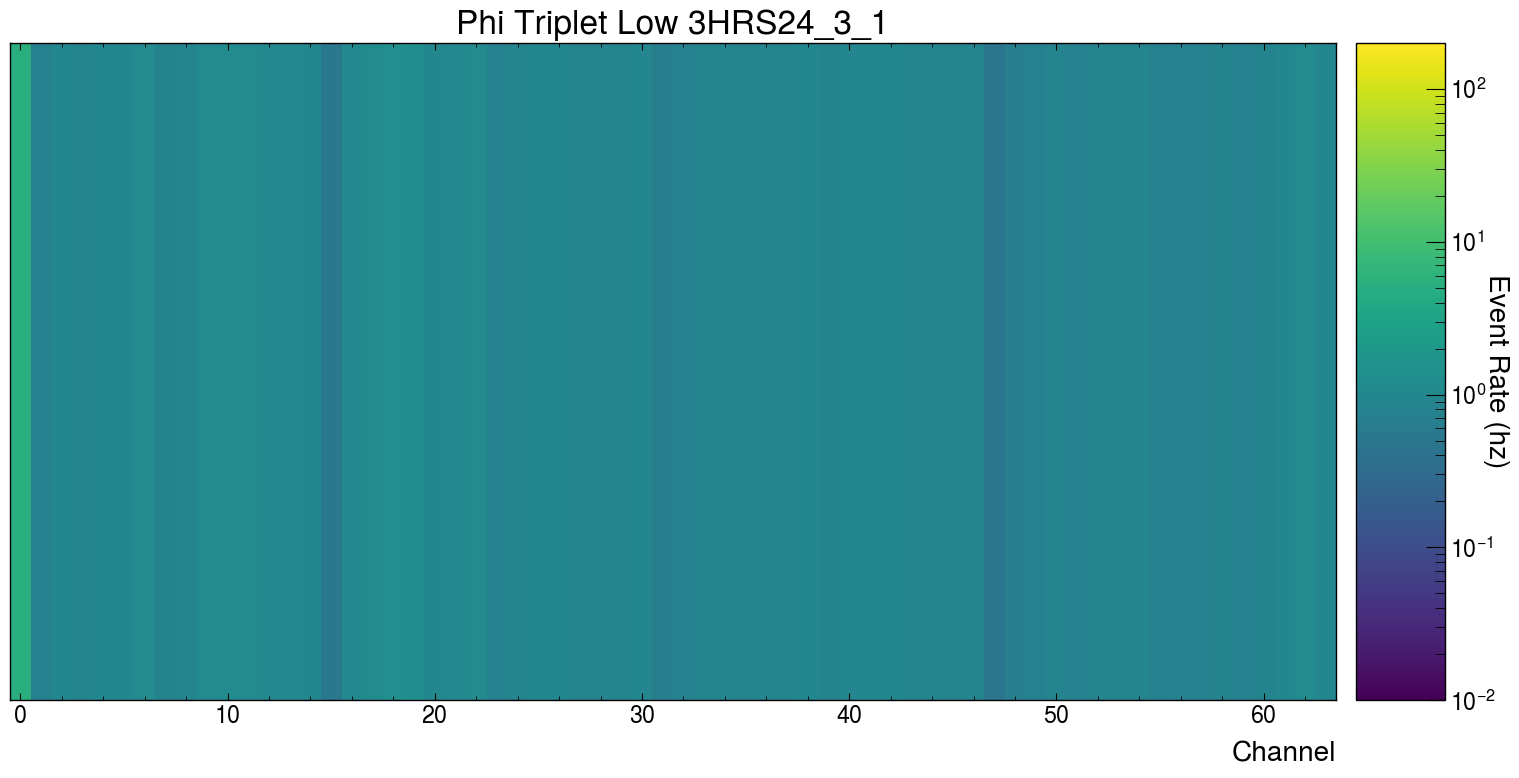

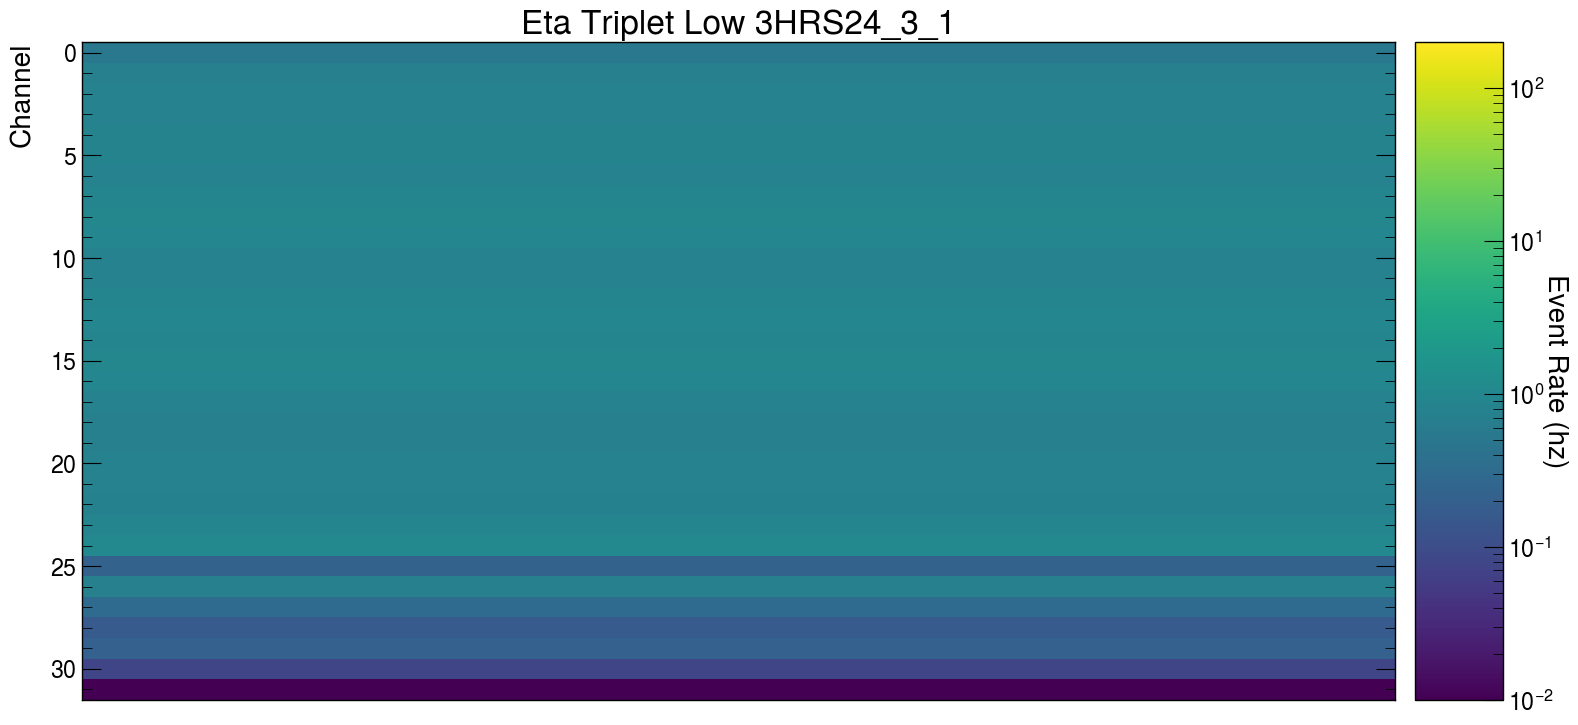

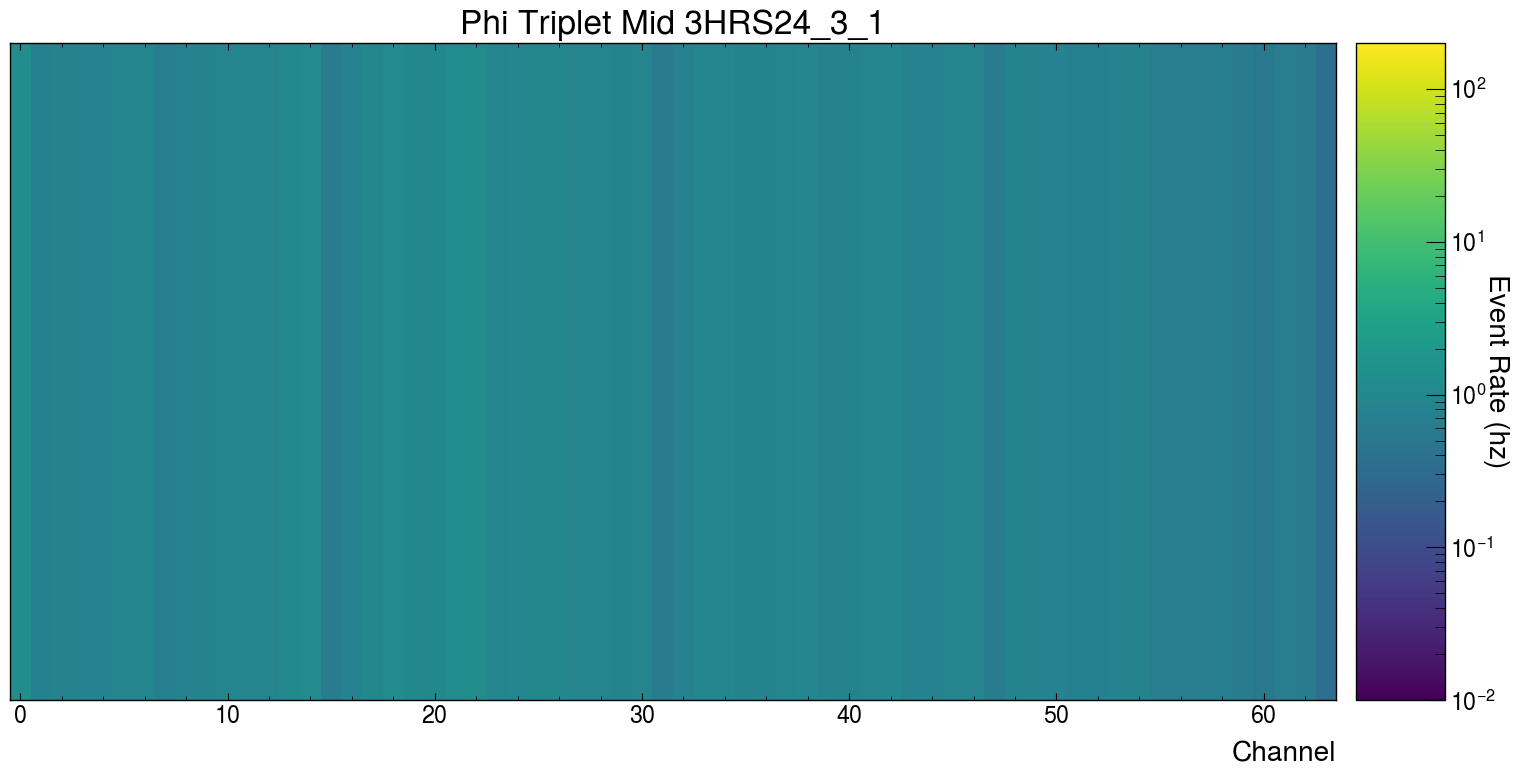

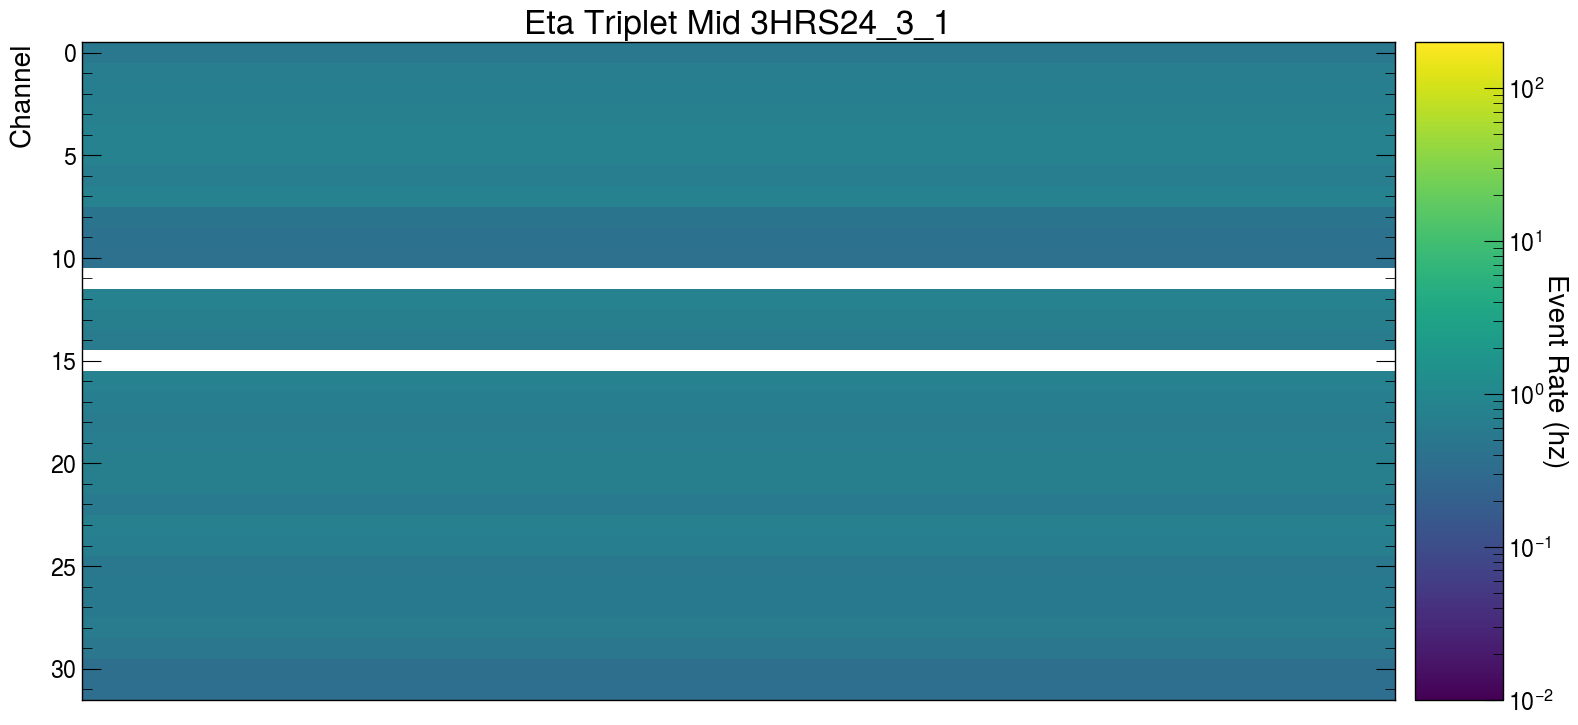

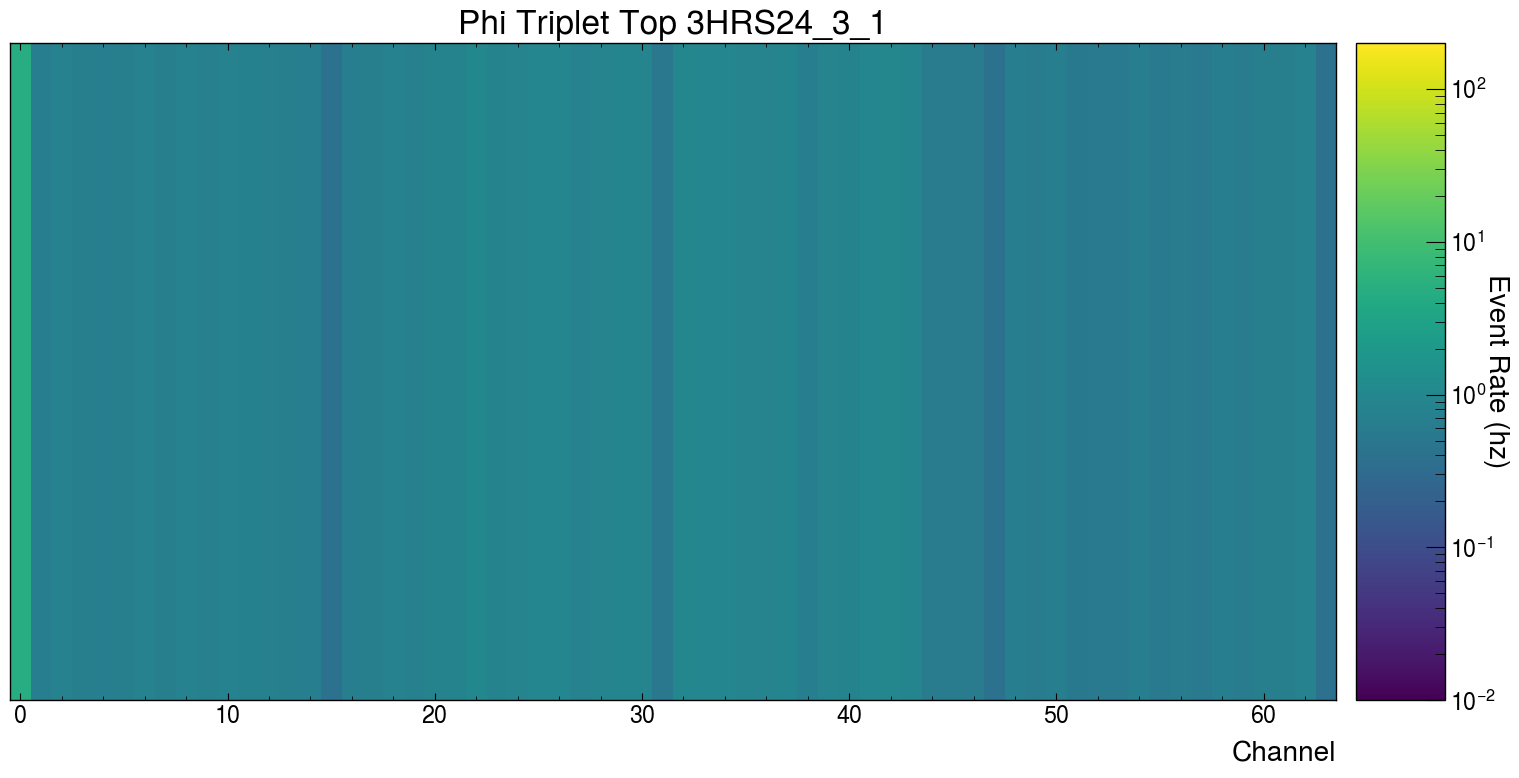

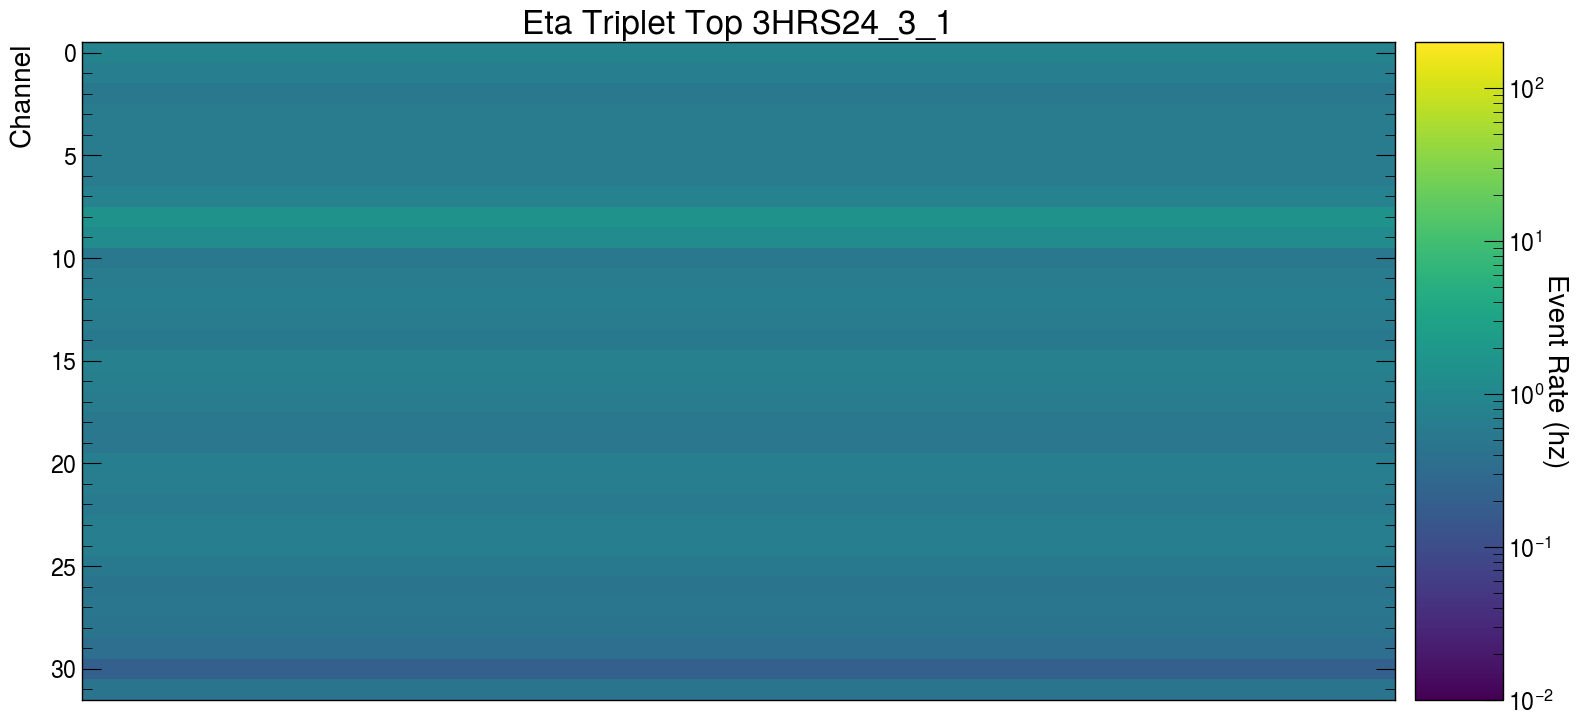

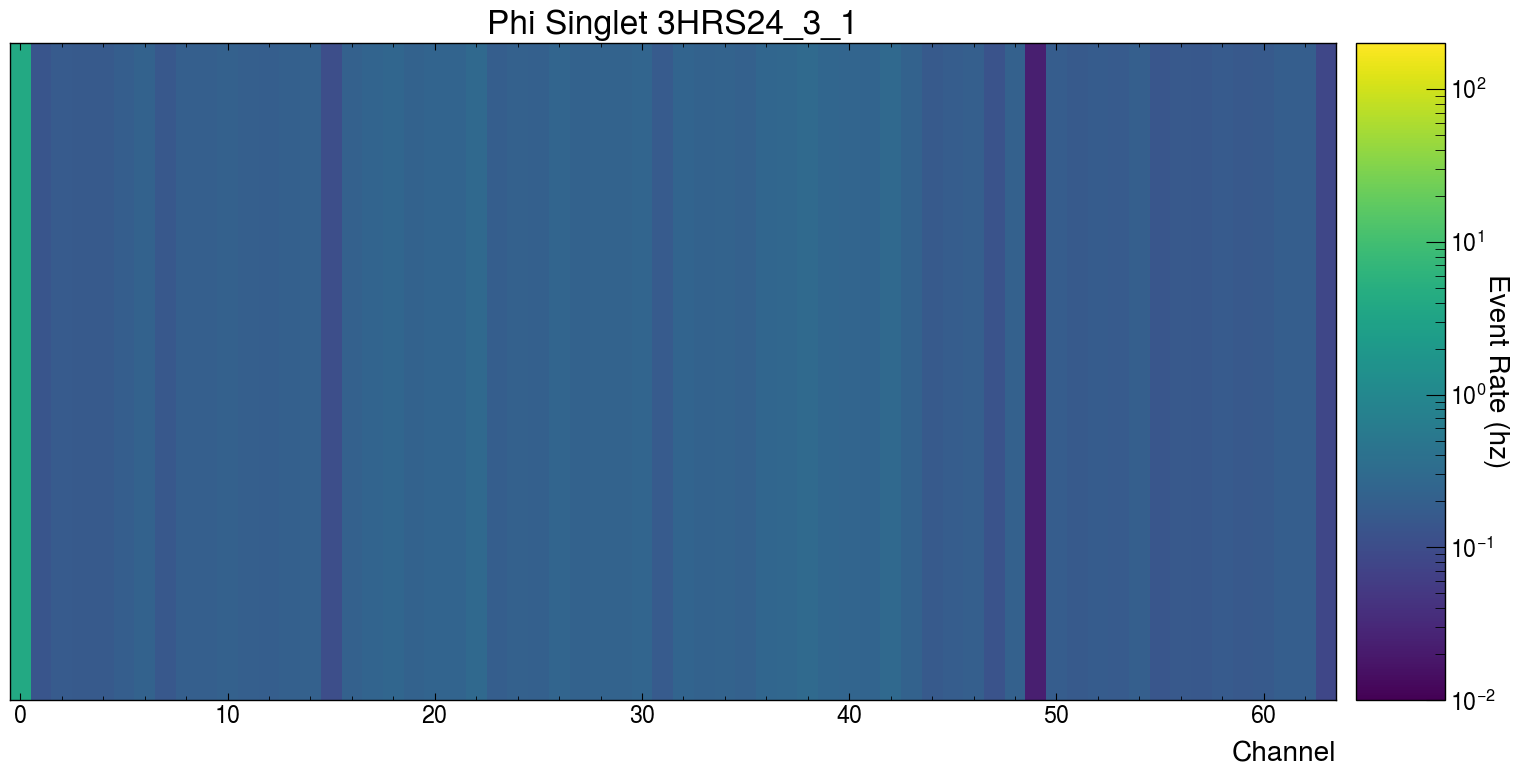

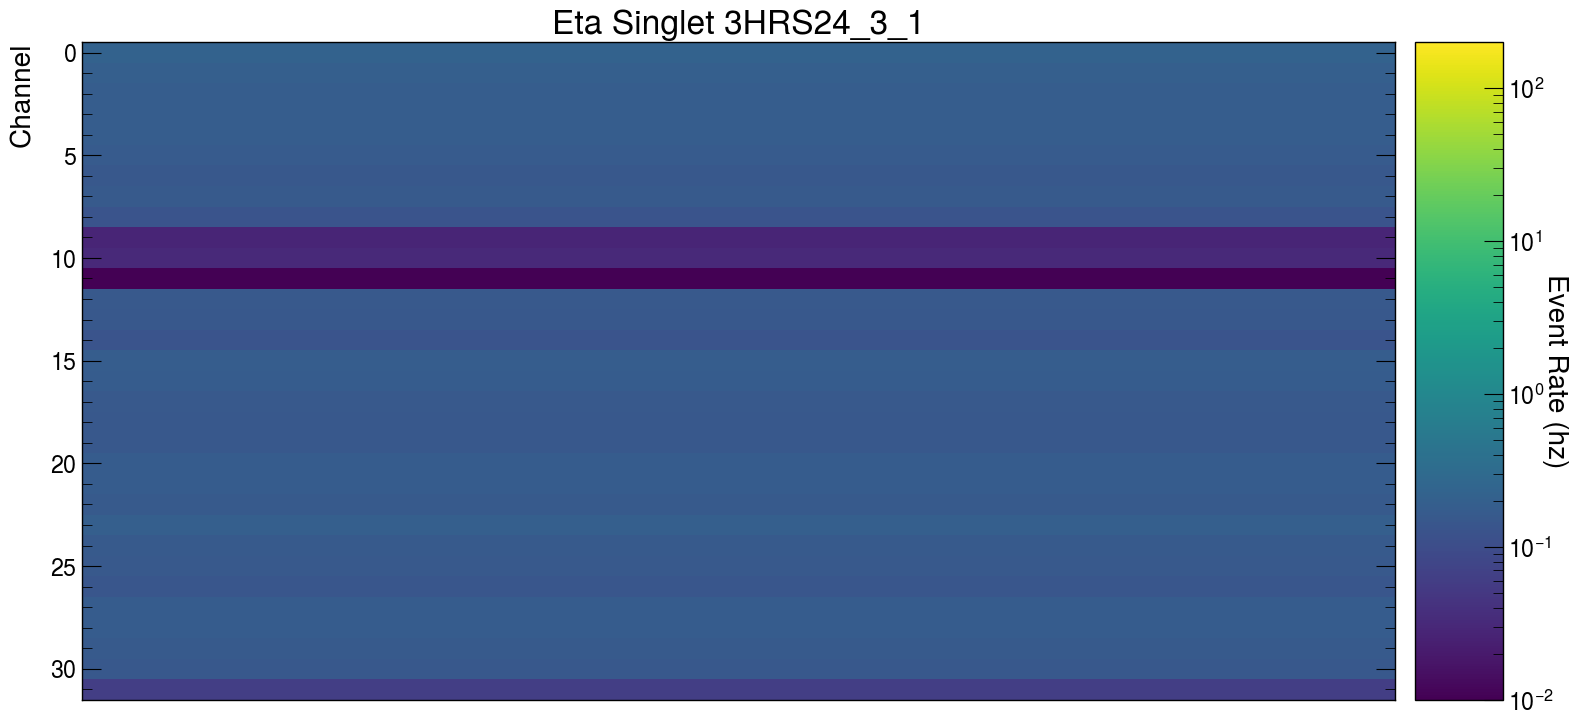

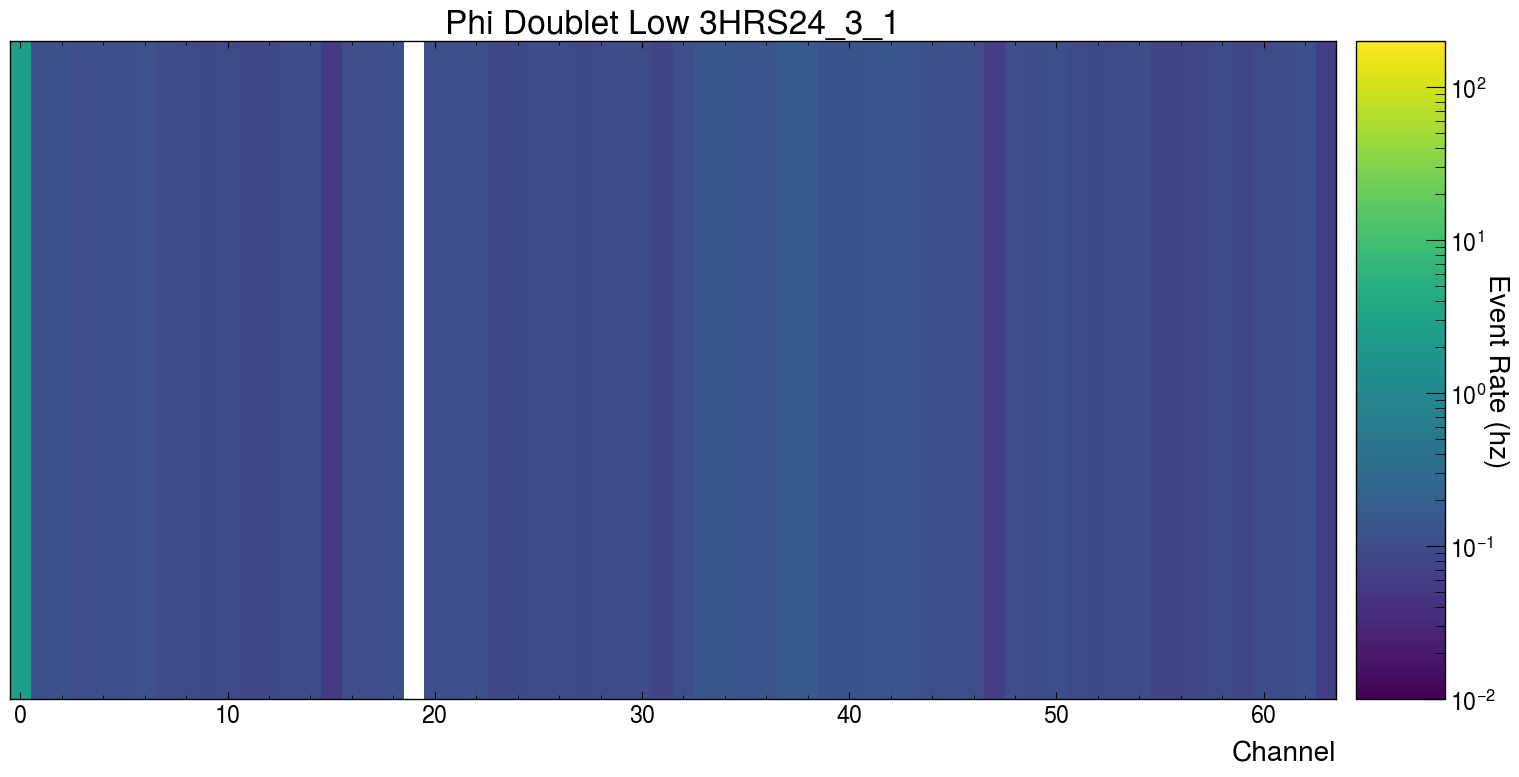

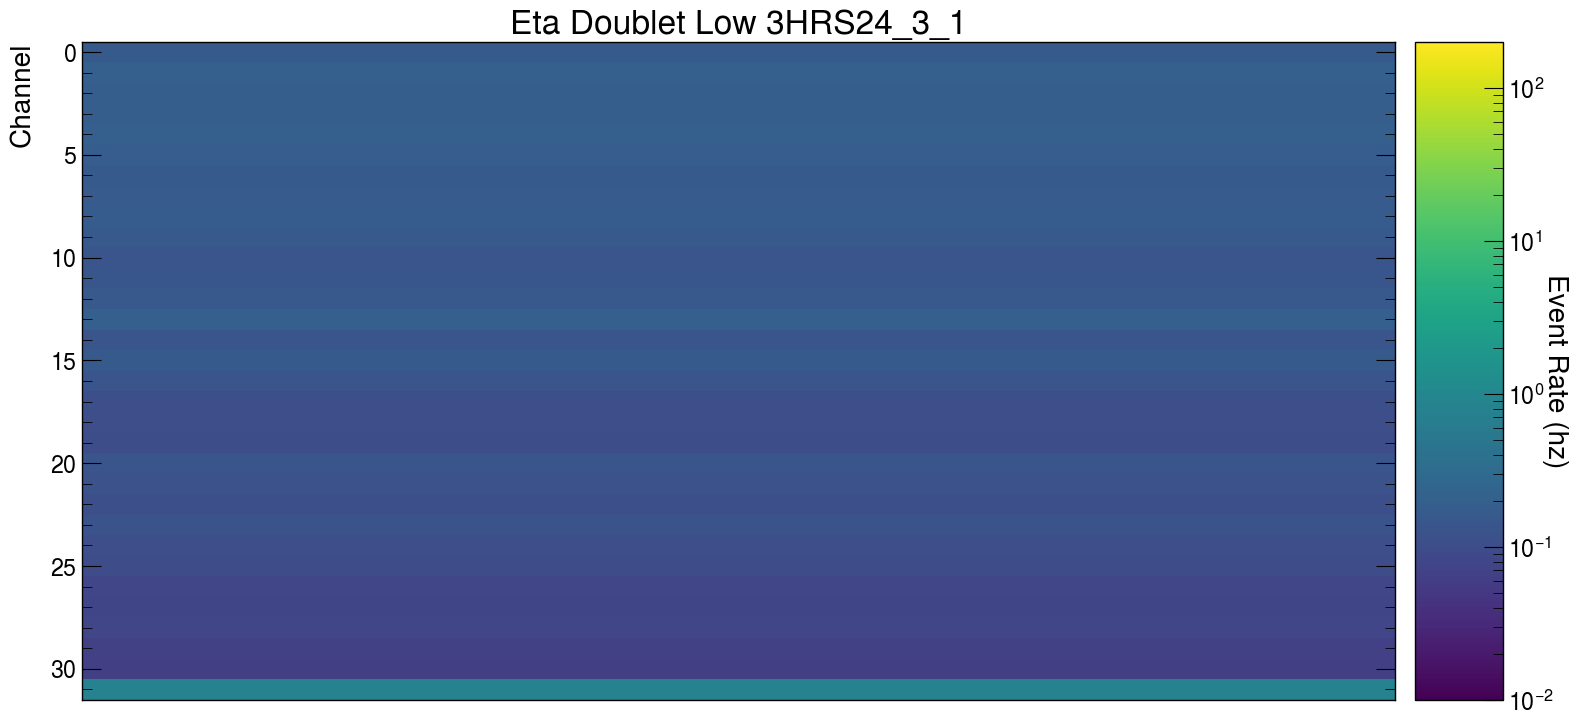

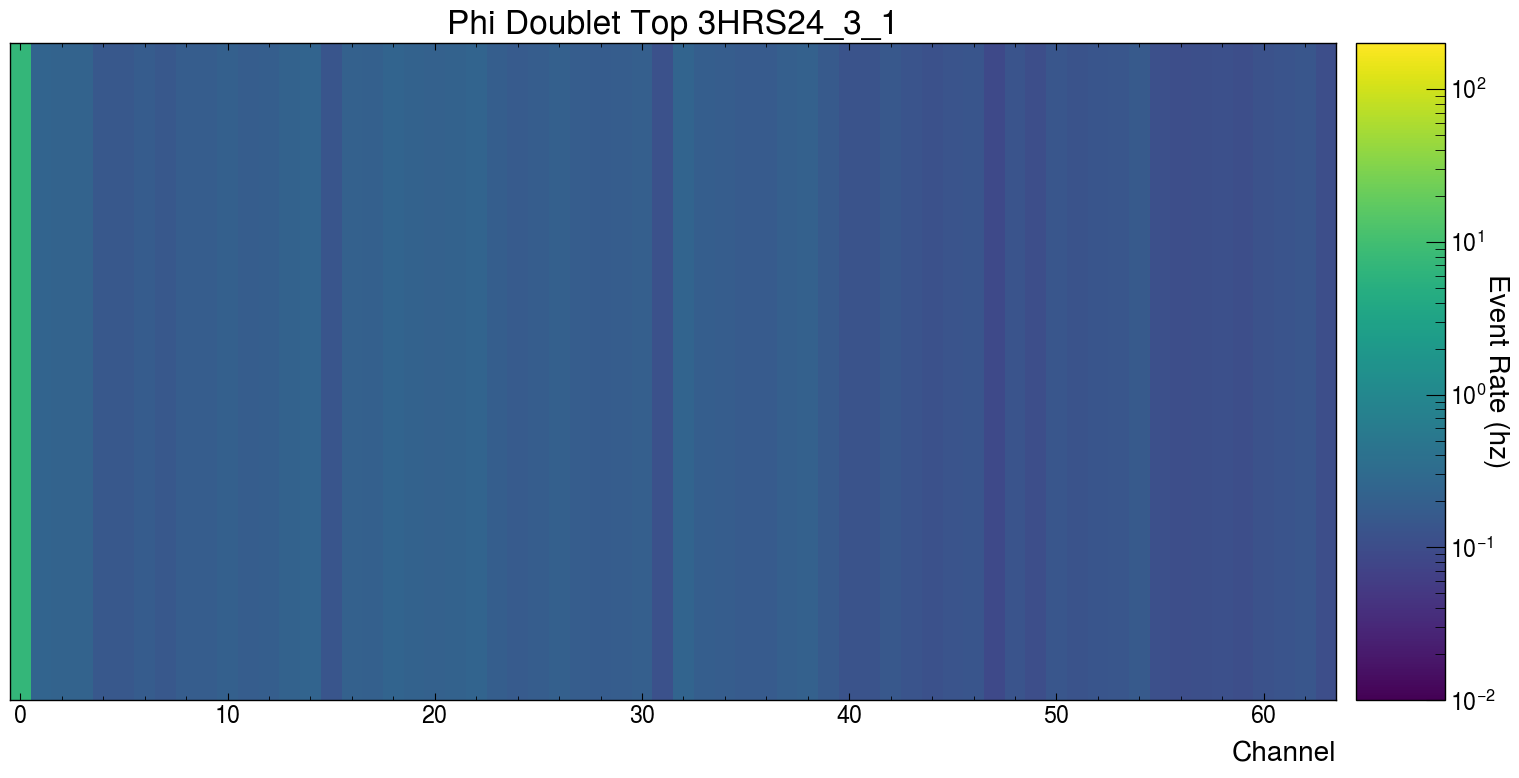

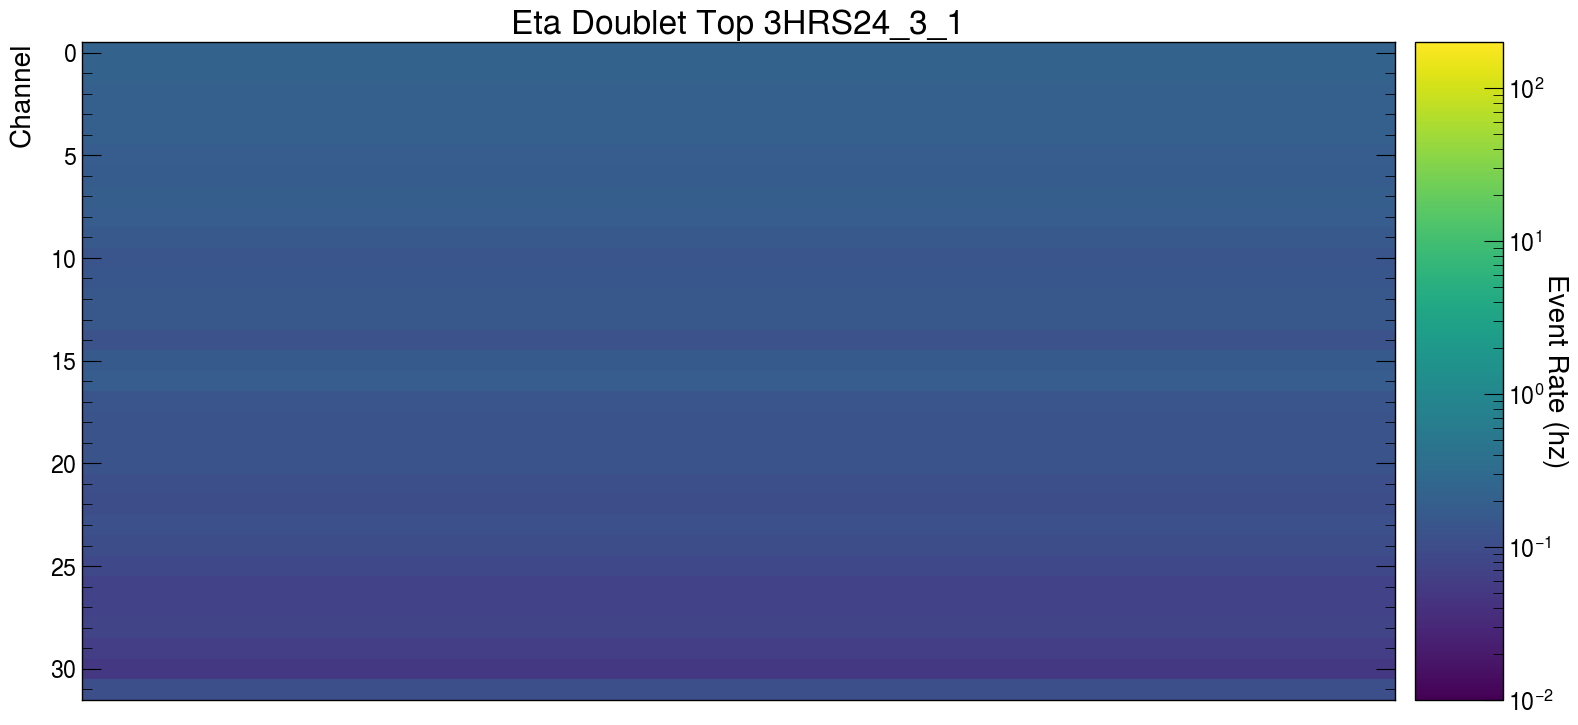

In [18]:
heatFromFile(current_directory+"\\ProAnubisData\\threeHourRun_24_3_1.h5",10800,"3HRS24_3_1")